In [2]:
import os, glob, copy
import numpy as np
import nrrd, scipy
import matplotlib.pyplot as plt
import plotting_help_py37 as ph
import orn_pn_matching_imaging as im
import orn_pn_matching as opm
import tifffile as tiff
from skimage import measure
import matplotlib.gridspec as gridspec
from matplotlib import animation
from IPython import display
import matplotlib as mpl 
from scipy import ndimage
from matplotlib import rcParams

mpl.rcParams['animation.ffmpeg_path'] = '../ffmpeg'
rcParams['text.usetex'] = True
plt.rcParams.update({'text.usetex': True})
import warnings
warnings.filterwarnings("ignore")

In [11]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Requirements:
1. the centroids of left and right AL do not cross midline
2. AL orientation between 0-90˚
3. always two blobs of 0-value pixels for the two lobes
4. a problem, not zeroing out-of-boundary data yet, weird

In [5]:
genotype = '35D04_AD-11F02_DBD-mGL-32hAPF-3'
folder = '../../1_Data/confocal/1_splits/0_goodgoods/0_analysis/'

recs = im.get_recs(genotype, parent_folder=folder)
rec = recs[0]

In [16]:
N = 100
folder = '../../1_Data/confocal/1_splits/0_goodgoods/0_analysis/'
# fn = 'Atonal_Gal4-GFP--GH146_QF2-tdT-24-26-APF-1'
fn = 'Arc_AD-AM29_DBD-mGL-33hAPF'
rec = im.AntennaLobe_vertical(folder=folder, filename=fn, lobe_side=0, ch_ORN=0, ch_NCad=1, ch_PN=2,)

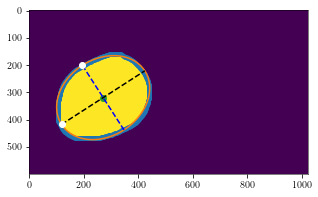

In [17]:
im.plot_mask_ellipse(rec)

In [20]:
chs = [0, 1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


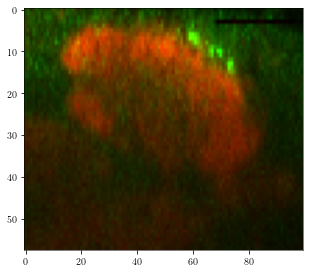

In [25]:
im.plot_single_verticalsection(rec, chs, RGB=[1,0,2], istep=50)

Text(0, 0.5, 'theta')

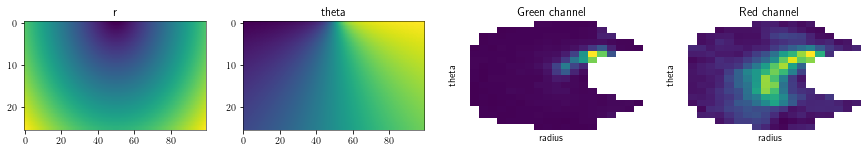

In [41]:
Mr, Mtheta, MG, MR, ts, rs = rec.get_vertical_Matrix(istep=50, window_halfwidth_ratio=1.5, ntheta=18, nr=20, rmax=70,)

# plot
fig = plt.figure(1, [15,2])
gs = gridspec.GridSpec(1, 4)

ax = plt.subplot(gs[0, 0])
ax.imshow(Mr, aspect='auto')
_ = ax.set_title('r')

ax = plt.subplot(gs[0, 1])
ax.imshow(Mtheta, aspect='auto')
_ = ax.set_title('theta')

ax = plt.subplot(gs[0, 2])
ax.imshow(MG, aspect='auto')
_ = ax.set_title('Green channel')
ph.adjust_spines(ax,[])
ax.set_xlabel('radius')
ax.set_ylabel('theta')

ax = plt.subplot(gs[0, 3])
ax.imshow(MR, aspect='auto')
_ = ax.set_title('Red channel')
ph.adjust_spines(ax,[])
ax.set_xlabel('radius')
ax.set_ylabel('theta')

### flat plot

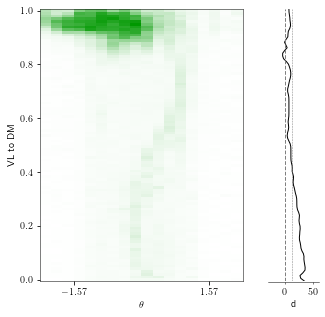

In [9]:
im.plot_heatmap_distance(rec,)

In [12]:
im.makemovie_verticalAL_ncadaxon(rec)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


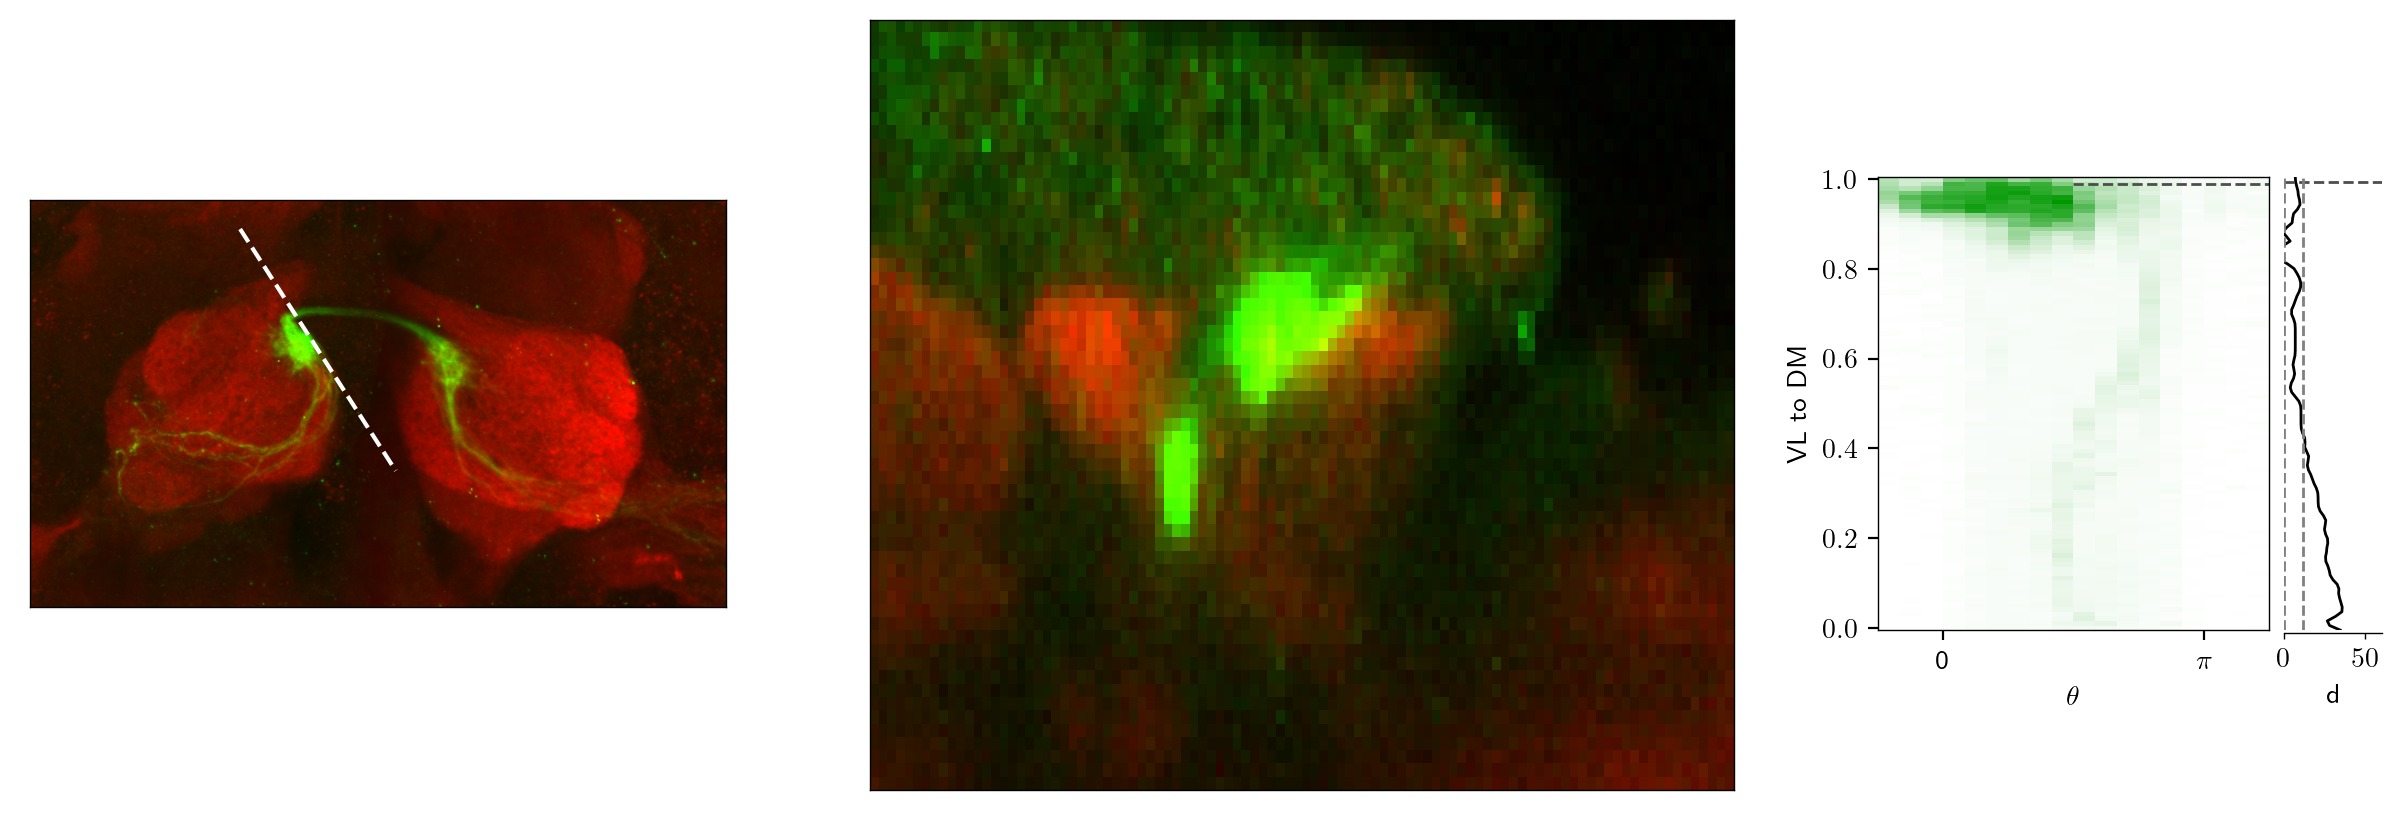

In [97]:
im.makemovie_verticalAL_2mv(rec, Nframes=100, dpi=200, moviename='DM6', fs=10, factor_G=1)

In [18]:
Mflat.shape

(100, 18)

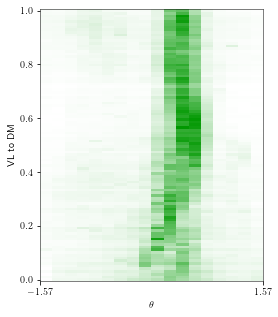

In [44]:
Ms = []
for rec in recs:
    Mflat, ts, rs = rec.get_Mflat()
    if not rec.lobe_side:
        Mflat = Mflat[:,::-1]
    Ms.append(Mflat)
Ms = np.array(Ms)
im.plot_heatmap((np.nanmean(Ms, axis=0), ts, rs),)

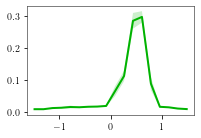

In [58]:
lim = [0.5, 0.6]
inds = (rs >= lim[0]) & (rs <= lim[1])

ys = []
for M in Ms:
    y = np.nanmean(M[inds,:], axis=0)
    ys.append(y/np.nansum(y))     # normalized: density
ym = np.nanmean(ys, axis=0)
ysem = scipy.stats.sem(ys, axis=0)

ax = ph.large_ax([3,2])
ax.plot(ts, ym, c=ph.green, lw=2)
ax.fill_between(ts, ym-ysem, ym+ysem, facecolor=ph.green, edgecolor='none', alpha=.2)

## misc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


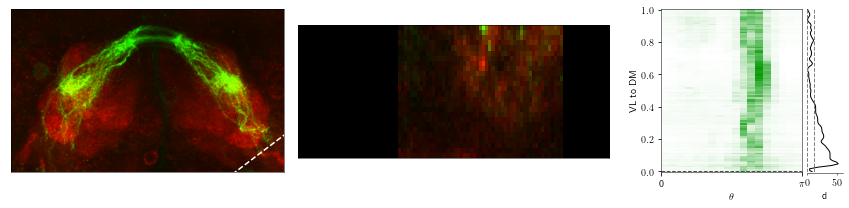

In [669]:
istep = 0
thresh_G=.2
window_halfwidth_ratio=1.5
ntheta=18
nr=20
rmax=70

fig_x = 12
fig_y = 3
window_halfwidth = window_halfwidth_ratio * rec.bp
zx_ratio = rec.Z * rec.zf / (2 * window_halfwidth * rec.xf)

# gs = gridspec.GridSpec(1, 4, width_ratios=[1,1,1,.25])
# ax0 = plt.subplot(gs[0,0])
# ax1 = plt.subplot(gs[0,1])
# ax2 = plt.subplot(gs[0,2])
# ax3 = plt.subplot(gs[0,3])


fig = plt.figure(1, [fig_x, fig_y])
gs0 = gridspec.GridSpec(1,1)
gs0.update(left=0.01, right=0.36, wspace=0)
ax0 = plt.subplot(gs0[0,0])

x = fig_x*(0.72-0.36)*zx_ratio/fig_y
gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.36, right=0.72, bottom=0.5*(1-x), top=0.5*(1+x), wspace=0)
ax1 = plt.subplot(gs1[0,0])

gs2 = gridspec.GridSpec(1,2,width_ratios=[4,1])
gs2.update(left=0.78, right=.99, wspace=0.06)
ax2 = plt.subplot(gs2[0,0])
ax3 = plt.subplot(gs2[0,1])

#ax0
x0_, y0_ = rec.xas[0], rec.yas[0]
xs_ = np.linspace(x0_ - window_halfwidth * np.sin(rec.phi), x0_ + window_halfwidth * np.sin(rec.phi), rec.N)
ys_ = np.linspace(y0_ + window_halfwidth * np.cos(rec.phi), y0_ - window_halfwidth * np.cos(rec.phi), rec.N)
imgG = np.nanmax(rec.tifs[:,:,:,0], axis=-1)
imgR = np.nanmax(rec.tifs[:,:,:,1], axis=-1)
imgB = np.zeros_like(imgG)
img_RGB = np.dstack([imgR/np.max(imgR)*fR,imgG/np.max(imgG)*fG,imgB/np.max(imgB)])
ax0.imshow(img_RGB)
line0 = ax0.plot(xs_,ys_, c='white',ls='--')
ax0.set_xlim([0,rec.X])
ax0.set_ylim([0,rec.Y])
ax0.set_xticks([])
ax0.set_yticks([])
ax0.invert_yaxis()    # must be stated after set_ylim

#ax1
# fig = plt.figure(1, [figwidth, figwidth * zx_ratio])
imgG, imgR, _ = rec.get_vertical_img(istep, window_halfwidth_ratio)
imgB = np.zeros_like(imgG)
img_RGB = np.dstack([imgR[::-1, :], imgG[::-1, :], imgB[::-1, :]])
img = ax1.imshow(img_RGB, aspect='auto')
ax1.set_xticks([])
ax1.set_yticks([])

#ax2,3
Mflat, ts, rs = rec.get_Mflat(window_halfwidth_ratio=1.5, ntheta=18, nr=20, rmax=70,)
ys, ys_sm = rec.get_d_axon2ncad(thresh_G=thresh_G)
ax2.pcolormesh(ts, np.linspace(0,1,rec.N), Mflat, cmap=ph.Greens)
line2 = ax2.axhline(istep/100., c=ph.grey7,ls='--', lw=1)
ax2.set_xlabel(r'$\theta$')
ax2.set_ylabel('VL to DM')
ax2.set_xticks([0,3.14])
ax2.set_xticklabels(['0',r'$\pi$'])
_= ax2.set_yticks(np.linspace(0,1,6))

# ax3 = plt.subplot(gs(left=0.8,right=1,top=1,bottom=0.3))
ax3.plot(ys_sm, np.linspace(0,1,rec.N), c='k',lw=1)
line3 = ax3.axhline(istep/100., c=ph.grey7,ls='--', lw=1)
ph.adjust_spines(ax3, ['bottom'], xlim=[0,60], ylim=(0,1), xticks=[0,50])
ax3.axvline(0, c='grey', ls='--',lw=1)
ax3.axvline(12, c='grey', ls='--',lw=1)
ax3.set_xlabel('d')


# plot each frame
def animate(i):
    i_frame = i
    istep = i_frame

    x0_, y0_ = rec.xas[istep], rec.yas[istep]
    xs_ = np.linspace(x0_ - window_halfwidth * np.sin(rec.phi), x0_ + window_halfwidth * np.sin(rec.phi), rec.N)
    ys_ = np.linspace(y0_ + window_halfwidth * np.cos(rec.phi), y0_ - window_halfwidth * np.cos(rec.phi), rec.N)
    line1.set_data(x0_, y0_)
    
    imgG, imgR, _ = rec.get_vertical_img(istep, window_halfwidth_ratio)
    imgB = np.zeros_like(imgG)
    img_RGB = np.dstack([imgR[::-1, :], imgG[::-1, :], imgB[::-1, :]])
    img.set_data(img_RGB)
    
#     line2.set_data(istep/100.)
#     line3.set_data(istep/100.)

    return fig,

# anim = animation.FuncAnimation(fig, animate, frames=10, interval=t_itv_ms, blit=True)

# if True:
#     video = anim.to_html5_video()
#     html = display.HTML(video)
#     display.display(html)
#     plt.close()